In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.special import kl_div

import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
import subprocess
import random
import time 

from utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

2024-06-12 10:00:14.298601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 10:00:15.321898: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 10:00:15.408928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-12 10:00:15.408960: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
from platform import python_version
python_version()

'3.7.7'

# Section 1: Helper functions and set-ups 

In [4]:
## Graphing set-up 
import seaborn as sns
x = np.linspace(-4, 4, 100)
tencent_blue = (0,0.3215686274509804,0.8509803921568627)
tencent_orange = (0.9333333333333333, 0.49411764705882355, 0.2784313725490196)

# Calculate y-values for the standard normal density curve
y_standard_normal = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

# Section 3: Simultation 

In [5]:
## Modifying the tensor for 3d input 
class MyModel_multiple(Model):
    def __init__(self, k, num_treats):
        super(MyModel_multiple, self).__init__()
        self.k = k
        self.num_treats = num_treats
        self.groupNames = ['A'] + ['B' + str(i+1) for i in range(self.num_treats)]
        self.baseline_logit = Dense(1, activation = "linear")
        self.outcome = Dense(1, activation = "linear")
        self.logit_dense_layer = {} 
        for g in self.groupNames:
            self.logit_dense_layer[g] = Dense(1, activation = "linear")
        self.softmax = tf.keras.activations.softmax
        
    
    def call(self, inputs):

        split_structure =  [2] + [1] * self.num_treats + [1]
        splitted_elements = tf.split(inputs, split_structure, axis=2)
        x1 = splitted_elements[0]
        exposure = tf.squeeze(splitted_elements[self.num_treats + 1], axis=-1)
        _, K, dim_x = x1.shape
        
        
        ## Step 1: Reshape the input 
        reshape_x1 = tf.reshape(x1, (-1, dim_x))
        
        ## Step 2: Score 
        ### Baseline logit
        x1_final = self.baseline_logit(x1)
        
        ### Uplift
        for i in range(self.num_treats):
            w_g = splitted_elements[i + 1]
            xg_hidden = self.logit_dense_layer['B'+str(i+1)](x1)
            x1_final = tf.add(tf.multiply(w_g, xg_hidden), x1_final)
            
        ## Step 3: Softmax
        logit = tf.reshape(x1_final, (-1, self.k))
        softmax_p =  self.softmax(logit, axis=-1)

        ## Outcome 
        ypredicts = self.outcome(x1)
        ypredicts = tf.squeeze(ypredicts, axis=-1)

        y2 = tf.reduce_sum(tf.multiply(exposure, ypredicts), axis = 1, keepdims=True)
        res = tf.concat([softmax_p, logit, y2, ypredicts], axis=1)
        return res

# Define custom loss function
def custom_loss(y_true, y_pred):
    y1_true, y2_true = tf.split(y_true, [K, 1], axis=1)
    _, y1_logit_pred, y2_pred, _= tf.split(y_pred, [K, K, 1, K], axis=1)
    loss1 = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y1_true, y1_logit_pred)
    loss2 = tf.keras.losses.MeanSquaredError()(y2_true, y2_pred)
    return loss1 + loss2

In [6]:
## Modifying the tensor for 3d input 
class MyModel_true():
    def __init__(self, k, promo):
        self.k = k
        self.promo = promo
        
    
    def predict(self, inputs):

        X_goodbads, X_utility, W_matrix, exposure_matrix = np.split(inputs, [1,2,3], axis=2)
        logit = self.promo * W_matrix * X_goodbads + X_utility
        logit = np.squeeze(logit, axis=-1)
        softmax_p =  np.exp(logit) / np.sum(np.exp(logit), axis=1, keepdims=True)

        ypredicts = np.squeeze(X_utility, axis=-1)

        exposure = np.squeeze(exposure_matrix, axis=-1)

        y2 = np.sum(exposure * ypredicts, axis = 1, keepdims=True)
        res = np.concatenate([softmax_p, logit, y2, ypredicts], axis=1)
        return res



In [7]:
class MyModel_random():
    
    def predict(self, inputs):

        X_goodbads, X_utility, W_matrix, exposure_matrix = np.split(inputs, [1,2,3], axis=2)
        K = X_utility.shape[1]
        logit = np.ones_like(X_utility)
        logit = np.squeeze(logit, axis=-1)
        softmax_p = np.ones_like(logit) / K
        ypredicts = np.squeeze(X_utility, axis=-1)

        exposure = np.squeeze(exposure_matrix, axis=-1)

        y2 = np.sum(exposure * ypredicts, axis = 1, keepdims=True)
        res = np.concatenate([softmax_p, logit, y2, ypredicts], axis=1)
        return res


In [8]:
J = 30 
K = 5 
Q = 3000
uplift_factor = 1
truth_estimate, truth_stderr = find_ate_ground_truth(J, K, Q, uplift_factor)

L = 1

M = 500 ## Number of iterations for Hessian matrix estimation 
n_folds = 3

In [9]:
truth_estimate

0.016721388846273087

In [10]:
B = 1
epochs = 400
np.random.seed(int(time.time() * 1e8 % 1e8))
print("Start K = {}, Q = {}, J = {}".format(str(K), str(Q), str(J)))
for b in range(B):
    (X_utility, X_goodbads, query_matrix, utility_score_matrix, 
     treatment_dict, utility_score, good_bad_dict) = generate_environment(J, K, Q, uplift_factor)
    (query_matrix, X_goodbads, X_utility,W_matrix, exposure_matrix, 
     outcome_potential, X_logit) = DGP_new_heterogeneous(J, Q, K, uplift_factor, query_matrix, X_goodbads, 
                                                         X_utility, treat_control_pool = [True, False])
    observed_queries_treatment = np.sum(exposure_matrix * W_matrix, axis = 1 )
    observed_outcome = np.sum(outcome_potential * exposure_matrix, axis = 1 )
    T, C = observed_outcome[observed_queries_treatment == 1] , observed_outcome[observed_queries_treatment == 0]  
        
    
    ## Cross-fitting indices 
    all_inds = generate_indices(np.array(query_matrix).shape[0], n_folds)

    ## Iterate over each fold for cross-validation. 
    hfuncs_each_fold,  debias_terms_each_fold = {}, {}
    loss_each_fold = {}
    for f in range(n_folds):
        f_start, f_end = all_inds[f]
        f_size = f_end - f_start
        
        ## Cross-fitting
        X_goodbads_train, X_goodbads_test =  train_test_split(X_goodbads, all_inds, f) 
        X_utility_train, X_utility_test =  train_test_split(X_utility, all_inds, f)  
        W_matrix_train, W_matrix_test = train_test_split(W_matrix, all_inds, f) 
        exposure_matrix_train, exposure_matrix_test =train_test_split(exposure_matrix, all_inds, f) 
        observed_outcome_train, observed_outcome_test = train_test_split(observed_outcome, all_inds, f) 
        
        outcome_potential_train, outcome_potential_test = train_test_split(outcome_potential, all_inds, f)  
    
        inputs_3d_train = np.stack([X_goodbads_train, X_utility_train, W_matrix_train, exposure_matrix_train], axis = -1)
        inputs_3d_test = np.stack([X_goodbads_test, X_utility_test, W_matrix_test, exposure_matrix_test], axis = -1)
        output_3d_train = np.concatenate([exposure_matrix_train.astype(dtype=float), observed_outcome_train[:, np.newaxis]], axis = 1)

        myModelMultiple = MyModel_multiple(K, 1)
        myModelMultiple.compile(loss=custom_loss, optimizer=tf.keras.optimizers.legacy.Adam())
        history_f = myModelMultiple.fit(inputs_3d_train, output_3d_train, epochs=epochs, verbose=True)
        
        ## Store the training history 
        
        loss_each_fold[f] = history_f
        predict_p_test, _, _, predict_outcome_test = np.split(myModelMultiple.predict(inputs_3d_test), [K, 2*K, 2*K+1], axis=1)

        input_3d_test_treat = np.stack([X_goodbads_test, X_utility_test, np.ones_like(W_matrix_test), exposure_matrix_test], axis = -1)
        input_3d_test_control = np.stack([X_goodbads_test, X_utility_test, np.zeros_like(W_matrix_test), exposure_matrix_test], axis = -1)
        
        predict_p_treat, _, _, predict_outcome_treat = np.split(myModelMultiple.predict(input_3d_test_treat), [K, 2*K, 2*K+1], axis=1)
        predict_p_control, _, _, predict_outcome_control = np.split(myModelMultiple.predict(input_3d_test_control), [K, 2*K, 2*K+1], axis=1)
        

        ## 1. COMPUTE THE GRADIENT OF LOSSS  
        gradient_vector_l = compute_loss_gradient(predict_p_test, exposure_matrix_test, W_matrix_test, 
                                                  predict_outcome_test, observed_outcome_test)




        ## 2. COMPUTE  THE GRADIENT OF H FUNCTION
        gradient_vector_H = compute_value_gradient(predict_p_treat, predict_outcome_treat, predict_p_control, predict_outcome_control)

        
        # 3. FIND THE EXPECTATION OF HESSIAN MATRIX 
        Hessian_all = np.zeros((f_size, (L+2) * K - 1,  (L+2) * K - 1))
        for m in range(M):
            treat_dict_m = permute_treatment_dict(J, L)
            W_matrix_m = []
            for each_query in query_matrix[f_start:f_end]:
                W_matrix_m.append([treat_dict_m[ind] for ind in each_query])
            W_matrix_m = np.array(W_matrix_m)
            inputs_m = tf.stack([X_goodbads_test, X_utility_test, W_matrix_m, exposure_matrix_test], axis = -1)
            predict_p_m, _, _, _ = np.split(myModelMultiple.predict(inputs_m), [K, 2*K, 2*K+1], axis=1)
            Hessian = compute_hessian_instance(W_matrix_m, predict_p_m)
            Hessian_all = Hessian_all + Hessian
        Hessian_final = Hessian_all / M
        
        count_finite = 0
        debias_term_f = np.zeros(len(Hessian_final))
        for i in range(f_size):
            if is_invertible(Hessian_final[i]):
                try:
                    debias_term_f[i] = gradient_vector_H[i]@np.linalg.inv(Hessian_final[i])@gradient_vector_l[i]
                    count_finite += 1 
                except: 
                    print("Fail for inversion")


        ## END OF FOR LOOP FOR EACH ITERATION OVER CROSS FITTING
        hfuncs_each_fold[f] = np.sum(predict_p_treat * predict_outcome_treat, axis=1) - np.sum(predict_p_control * predict_outcome_control, axis=1)
        debias_terms_each_fold[f] = debias_term_f
        
    (debias_point, debias_var, undebias_point, undebias_var) = crossfitted_estimate_var(hfuncs_each_fold, debias_terms_each_fold)
    dim_point, dim_var = dim_est(T, C, 0.5, Q)

    path = compose_filename(f"results1106{Q}/new_heterogeneous_synthetic_ab_j{J}q{Q}k{K}_100_{uplift_factor}", "csv")
    result_df = pd.DataFrame({"debias_point": [debias_point], "debias_var":[debias_var], "dim": [dim_point], 
                              "dim_var":[dim_var], "undebias_point": [undebias_point], "undebias_var": [undebias_var], 
                              "J" : [J], "Q": [Q],  "K":[K], "truth": [truth_estimate], "truth_stderr": [truth_stderr] })
    result_df.to_csv(path)
    print("finish simulation.")


Start K = 5, Q = 3000, J = 30
Epoch 1/400


2024-06-12 10:03:31.130400: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-12 10:03:31.132188: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-12 10:03:31.132237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (VM-209-192-centos): /proc/driver/nvidia/version does not exist
2024-06-12 10:03:31.134408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


63/63 [==============================] - 1s 1ms/step - loss: 6.1175
Epoch 2/400
63/63 [==============================] - 0s 1ms/step - loss: 4.7118
Epoch 3/400
63/63 [==============================] - 0s 1ms/step - loss: 3.7193
Epoch 4/400
63/63 [==============================] - 0s 1ms/step - loss: 3.0208
Epoch 5/400
63/63 [==============================] - 0s 1ms/step - loss: 2.5287
Epoch 6/400
63/63 [==============================] - 0s 1ms/step - loss: 2.1813
Epoch 7/400
63/63 [==============================] - 0s 1ms/step - loss: 1.9239
Epoch 8/400
63/63 [==============================] - 0s 1ms/step - loss: 1.7249
Epoch 9/400
63/63 [==============================] - 0s 1ms/step - loss: 1.5648
Epoch 10/400
63/63 [==============================] - 0s 1ms/step - loss: 1.4351
Epoch 11/400
63/63 [==============================] - 0s 1ms/step - loss: 1.3331
Epoch 12/400
63/63 [==============================] - 0s 1ms/step - loss: 1.2530
Epoch 13/400
63/63 [=============================

## Plots the training loss 

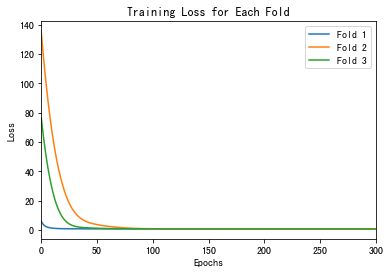

In [12]:
import matplotlib.pyplot as plt
  # assuming history_each_fold is your dictionary

# create a new figure
plt.figure()

# plot the training loss for each fold
for f in range(n_folds):
    plt.plot(loss_each_fold[f].history['loss'], label=f'Fold {f+1}')

# add title and labels
plt.xlim(0,300)
plt.title('Training Loss for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# add a legend
plt.legend()
plt.savefig("training_loss_simulation.png")

# show the

In [14]:
## Find the goodness of fit for outcome model 
rss = np.sum((outcome_potential_test - predict_outcome_treat) ** 2 )
tss = np.sum(outcome_potential_test ** 2 )
1 - rss / tss

0.9999999999999993

## NDCG loss 

In [15]:
probs_mat = predict_p_test
expos_mat = exposure_matrix_test
import tensorflow_ranking as tfr
def aggregate_probability_exposure_examination(probs_matrix, exposure_matrix): 
    aggregate_probs = np.mean(probs_matrix, axis = 0)
    exposure_probs = np.mean(exposure_matrix, axis = 0)
    ## Euclidean distance 
    euc_dist = np.linalg.norm(aggregate_probs - exposure_probs)
    ## NDCG LOSS 
    y_true = tf.ragged.constant(exposure_matrix)
    y_pred = tf.ragged.constant(probs_matrix)
    loss_NDCG = tfr.keras.losses.ApproxNDCGLoss(ragged=True)
    NDCG_loss_result = loss_NDCG(y_true, y_pred).numpy()
    return euc_dist, aggregate_probs, exposure_probs, NDCG_loss_result

def bootstrap_evaluation(probs_mat, expos_mat, B = 100):
    nrows = probs_mat.shape[0]
    kl_div_list, NDCG_list = [], []
    for b in range(B):
        indices = np.random.choice(nrows, size=nrows, replace=True)
        probs_mat_b = probs_mat[indices,:]
        expos_mat_b = expos_mat[indices,:]

        _, agg_probs_b, agg_expos_b, NDCG_b = aggregate_probability_exposure_examination(probs_mat_b, expos_mat_b)
        kl_divergence_b = kl_div(agg_probs_b,agg_expos_b).sum()

        kl_div_list += [kl_divergence_b]
        NDCG_list += [NDCG_b]

    return kl_div_list, NDCG_list 

In [16]:
kl_, ndcg_ = bootstrap_evaluation(probs_mat.astype(np.float32), expos_mat.astype(np.float32), B = 100)
final_kl =[]
for elm in kl_:
    if np.isfinite(elm):
        final_kl += [elm]
        
final_ndcg =[]
for elm in ndcg_:
    if np.isfinite(elm):
        final_ndcg += [elm]
        

In [17]:
res_boot_ndcg_uniform = bootstrap_evaluation(1/K+ 0 * probs_mat.astype(np.float32), expos_mat.astype(np.float32), B = 1 )
# final_kl_uniform =[]
# for elm in res_boot_ndcg_uniform[0]:
#     if np.isfinite(elm):
#         final_kl_uniform += [elm]
        
# final_ndcg_uniform =[]
# for elm in res_boot_ndcg_uniform[1]:
#     if np.isfinite(elm):
#         final_ndcg_uniform += [elm]
        

-0.5

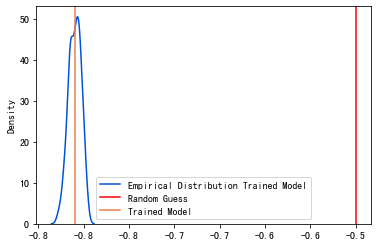

In [26]:
import matplotlib.ticker as ticker

# Your existing code
sns.kdeplot(final_ndcg, color=tencent_blue, label="Empirical Distribution Trained Model")
plt.axvline(x=res_boot_ndcg_uniform[1][0], color="red", label="Random Guess")
plt.axvline(x=np.mean(final_ndcg), color=tencent_orange, label="Trained Model")
plt.legend()

# New code to format x-axis labels
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

plt.savefig("NDCG_simulation.png")

## Likelihood Ratio Test

In [28]:
import numpy as np
from scipy.stats import chi2

# assuming you have the true labels and predicted probabilities
y_true = expos_mat
y_pred = probs_mat  # predicted probabilities

# calculate log-likelihood for null model
LL_null = np.sum(y_true * np.log(1/K) + (1 - y_true) * np.log(1- 1/K))

# calculate log-likelihood for choice model
LL_model = np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# calculate test statistic
LR = -2 * (  LL_null -LL_model)

# calculate p-value
p_value = chi2.sf(LR, df=K)

In [29]:
LR

2130.032891817788

In [30]:
p_value

0.0